In [126]:
# STEP 1 - 의존성 로드 - O

# STEP 2 - 데이터 임포팅 - O

# STEP 3 - KNN 으로 missing value filling 
# -> O (민경 코드)

# STEP 4 - Data 자체의 구조와 분석 
# -> (histogram-O, pairplot-O, HC-진행중)

# STEP 5 = 변수간 상관관계 및 다중공선성(VIF) 분석 
#-> (상관관계-O,다중공선성-일부변수에 대해서만 수행->진행) 

# STEP 6 - 변수의 RF 모델에서 나온 중요도 산출 
#-> O // 날리고 살릴 기준이 필요

# STEP 7 - step5, step 6의 결론을 토대로 변수 drop 
#-> 최종 관심 변수 선택 - 

# STEP 8 - 파이프라이닝 - 스케일링 / 모델링 결정 
#-> 모델별로 달라서 어렵다

# STEP 9 - 피팅한 모델들의 성능 비교 후 
#-> 현재 2형 오류가 너무 많음 

# STEP 10 - 최종 관심 변수가 입력된 단일 샘플의 당뇨병 예측 
#-> 코드 구현 필요 


In [70]:
# STEP 1 -  의존성 로드 ############################################################
import numpy as np
import pandas as pd
import os
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns # seaborn ref : https://greeksharifa.github.io/machine_learning/2019/12/05/Seaborn-Module/
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import statsmodels.api as sm;
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

In [84]:
# STEP 2 - 데이터 임포팅 ############################################################

df = pd.read_csv("desktop/2018_SEL_FILLED.csv") ## 파일리딩!
df.head()

,sex,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DI4_pr,DM1_pr,DM2_pr,DM3_pr,DM4_pr,DJ2_pr,DJ4_pr,DC1_pr,DC2_pr,DC3_pr,DC4_pr,DC5_pr,DC6_pr,DC7_pr,DF2_pr,DL1_pr,DJ0_pr,DJ6_pr,DH4_pr,DH2_pr,DH3_pr,DH6_pr,DN1_pr,DK0_pr,DKNaN_pr,DK4_pr,BHNaN_11,LQ4_00,LQ1_sb,LQ_5EQL,MH1_yr,MO1_wk,educ,EC1_1,BO1,BO1_1,BD1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS1_1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS9_2,BS13,BE3_71,BE3_31,HE_mens,HE_prg,HE_fh,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_HbA1c,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Usg,HE_Unitr,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_pef,HE_cough1,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_FAT,N_SFA,N_MUFA,N_PUFA,N_N3,N_N6,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_VA,N_VA_RAE,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR
0,1,80,2,1,3,7,7129.611906,11065.346820,48804.43027,14516.42326,12602.663140,3,20,2,80.000000,3,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,2,2,5,2,4,1,2,0,0,19,2,4,2,3,480,480,19,3,2,2,6,0,0,0,0,0,0,162.4,56.0,82.2,21.233226,6.0,2,2,111,43,83,0.55,0.08,12.9,38.7,27,1.48,6.5,1.010,0,0,0,0,0,0,0,2.5700,1.4,68.9,87,35,3.12,6.16,0,0,5,19.2,16.8,5.0,584.617278,843.068846,413.229839,36.421414,18.767787,6.574070,5.710856,4.365616,0.573964,3.800031,104.511252,97.066580,8.024705,14.110607,137.524220,467.694365,4.771832,1327.693537,944.539521,157.018937,115.820413,494.382289,74.621889,0.664332,0.509876,4.700086,5.846040,53.215661,10
1,1,78,5,5,4,1,7129.611906,3688.448941,19970.18814,14516.42326,4200.887713,2,20,3,1500.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,2,2,7,1,4,1,2,0,0,15,5,4,3,0,300,420,0,3,2,2,4,0,0,0,0,0,0,167.7,76.4,98.3,27.166096,6.2,4,3,224,36,157,0.51,0.10,14.3,42.6,22,0.95,5.5,1.020,0,0,0,0,0,0,0,0.3960,1.4,100.1,182,38,3.22,8.94,0,0,5,40.5,35.9,5.0,1573.428467,1784.794052,1008.012946,93.260455,25.901406,7.572577,10.233699,3.178905,0.333173,2.843236,206.181421,298.257700,39.887760,93.915511,430.240874,941.809087,11.041512,4961.541083,3658.637056,274.952137,197.537509,928.975532,120.122882,1.175553,1.217959,16.821098,109.102194,83.316037,10
2,2,75,5,5,3,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,20,3,1500.000000,1,3,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,2,2,1,2,1,5,2,4,1,1,0,2,0,0,3,3,0,360,480,0,3,1,2,2,0,0,1,0,0,1,157.7,53.2,80.7,21.391845,5.2,2,3,165,44,101,0.59,12.06,14.3,42.3,15,0.57,6.0,1.024,0,0,0,0,0,0,0,0.7875,1.4,105.1,153,66,1.72,4.56,1,0,5,15.3,10.3,5.0,1194.733365,1984.263560,758.479721,42.516444,60.305901,23.130683,21.015233,12.467458,2.193219,10.279590,495.097017,320.072436,44.459450,120.949600,342.242264,842.370409,7.348493,2087.228977,3072.114196,948.965037,601.616567,4168.181635,254.268098,0.638100,1.337223,4.785608,96.546711,78.771586,10
3,2,80,2,1,1,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,20,1,75.666667,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,2,1,3,2,3,1,1,0,1,0,0,4,3,0,450,450,0,2,2,2,4,0,0,0,0,0,0,146.1,57.6,93.0,26.984977,7.3,4,3,160,32,229,0.52,0.06,10.3,30.2,23,0.98,5.0,1.013,0,0,0,0,0,0,0,0.4480,1.4,67.3,140,35,2.24,3.06,0,0,2,8.6,14.6,2.5,526.064249,1019.718446,271.549260,24.806971,7.543745,2.329953,1.939842,2.932005,0.356655,2.572942,3.729000,211.241049,16.174439,22.942586,146.555175,609.814863,5.071129,2886.722704,1244.294594,96.834167,48.430128,580.848469,0.026089,0.877007,0.305087,6.082442,10.749817,51.281633,10
4,2,71,2,1,4,7,7129.611906,3315.581424,19970.18814,14516.42326,3268.787290,2,20,1,75.666667,4,3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,2,1,7,2,2,1,2,0,1,21,1,4,3,0,300,360,0,3,2,2,0,0,0,1,0,0,1,157.2,53.2,78.4,21.528142,7.4,2,3,167,62,54,0.64,0.04,12.6,37.5,25,0.71,6.0,1.022,0,0,4,0,0,0,0,0.8110,1.4,62.7,159,38,2.43,5.89,0,0

In [72]:
# STEP 3 - KNN 으로 missing value filling ############################################################
#df=df.fillna(method='pad')

# df = pd.read_excel('test.xlsx')
# imputer = KNNImputer(n_neighbors=11)
# data_filled = imputer.fit_transform(df)
# data_filled = data_filled.astype('int64')
# download = pd.DataFrame(data_filled).to_csv('filled.csv')

# df = pd.read_excel('test.xlsx')
# data_filled = df.where(pd.notnull(df), df.median(), axis='columns')
# download = pd.DataFrame(data_filled).to_csv('filled.csv')

df=df.drop(df.columns[0], axis='columns') #unnamed drop 없을경우 주석 처리
df.isnull()

,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DI4_pr,DM1_pr,DM2_pr,DM3_pr,DM4_pr,DJ2_pr,DJ4_pr,DC1_pr,DC2_pr,DC3_pr,DC4_pr,DC5_pr,DC6_pr,DC7_pr,DF2_pr,DL1_pr,DJ0_pr,DJ6_pr,DH4_pr,DH2_pr,DH3_pr,DH6_pr,DN1_pr,DK0_pr,DKNaN_pr,DK4_pr,BHNaN_11,LQ4_00,LQ1_sb,LQ_5EQL,MH1_yr,MO1_wk,educ,EC1_1,BO1,BO1_1,BD1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS1_1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS9_2,BS13,BE3_71,BE3_31,HE_mens,HE_prg,HE_fh,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_HbA1c,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Usg,HE_Unitr,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_pef,HE_cough1,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_FAT,N_SFA,N_MUFA,N_PUFA,N_N3,N_N6,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_VA,N_VA_RAE,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

0       2
1       3
2       3
3       3
4       3
       ..
4721    1
4722    1
4723    1
4724    2
4725    1
Name: HE_DM, Length: 4726, dtype: int64

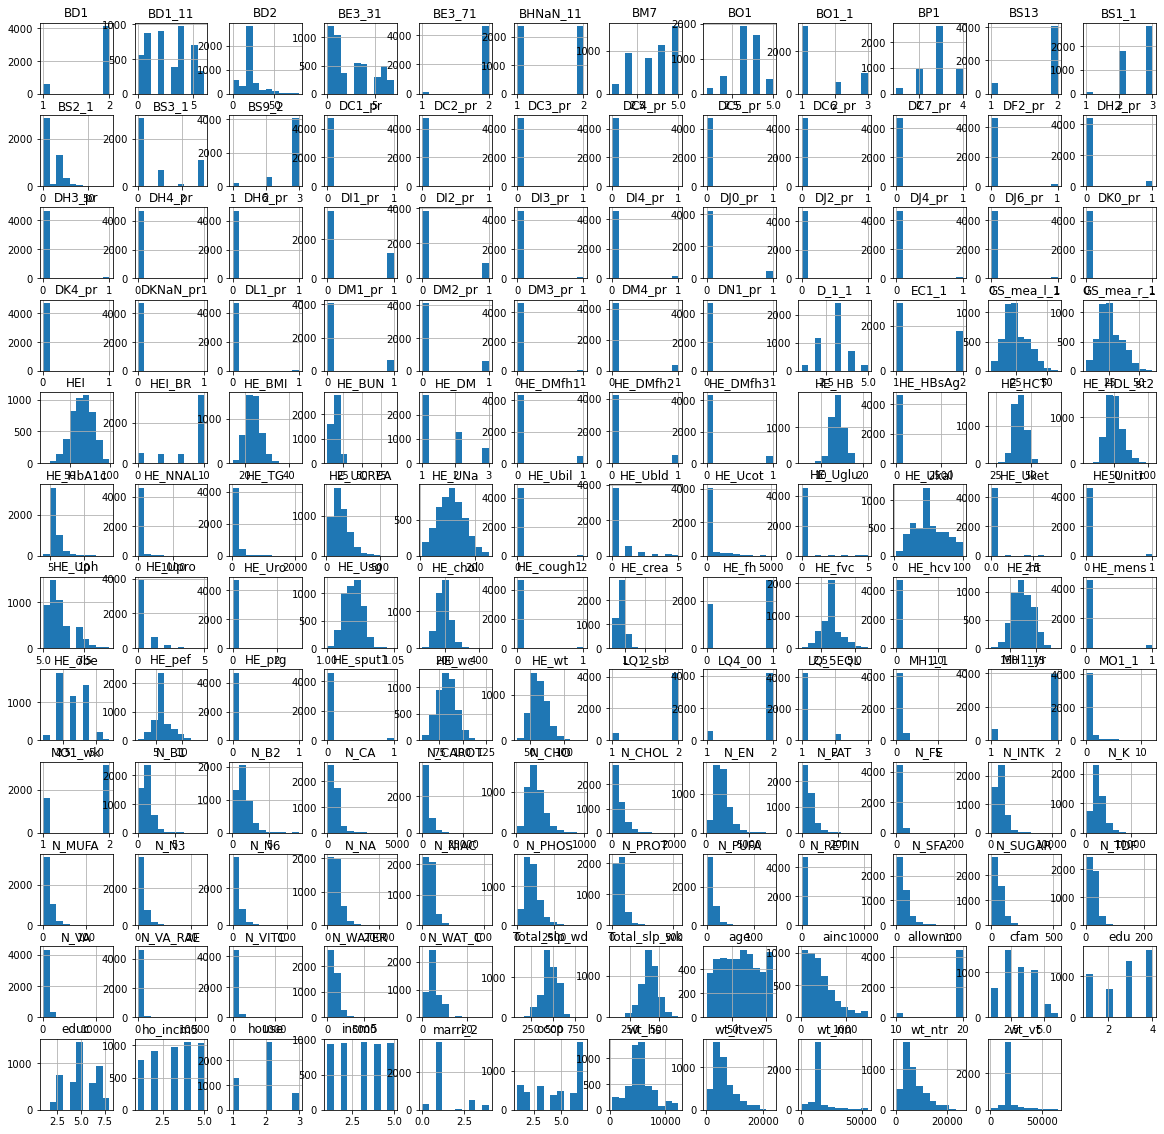

In [73]:
# STEP 4 - Data에 대한 구조와 분석
df.hist(figsize=(20,20))#histogram plotting
#sns.paiplot(df)
df.head()
df['HE_DM']

In [74]:
# STEP 5 = 변수간 상관관계 및 다중공선성(VIF) 분석 #################################################################### 

## 변수간 상관관계 분석 - 1 
t=df.corr(method='pearson') ## de1_pr 현재 당뇨병 유병 여부와 상관관계가 있는 변수들
t.HE_DM

age             0.280209
incm5          -0.067033
ho_incm5       -0.027450
edu            -0.214252
occp            0.123202
wt_hs           0.002368
wt_itvex       -0.057395
wt_vt          -0.011756
wt_nn          -0.029650
wt_ntr         -0.038942
cfam           -0.146654
allownc        -0.077856
house           0.016118
ainc           -0.160227
marri_2         0.077422
D_1_1           0.138468
DI1_pr          0.297300
DI2_pr          0.238316
DI3_pr          0.069801
DI4_pr          0.078165
DM1_pr          0.066197
DM2_pr          0.074549
DM3_pr         -0.011978
DM4_pr          0.028438
DJ2_pr         -0.007449
DJ4_pr          0.013580
DC1_pr          0.034264
DC2_pr         -0.007449
DC3_pr         -0.006160
DC4_pr         -0.013244
DC5_pr          0.009145
DC6_pr          0.005937
DC7_pr         -0.031831
DF2_pr          0.024265
DL1_pr         -0.021910
DJ0_pr         -0.093593
DJ6_pr          0.010324
DH4_pr          0.011215
DH2_pr          0.048866
DH3_pr          0.031392


,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DI4_pr,DM1_pr,DM2_pr,DM3_pr,DM4_pr,DJ2_pr,DJ4_pr,DC1_pr,DC2_pr,DC3_pr,DC4_pr,DC5_pr,DC6_pr,DC7_pr,DF2_pr,DL1_pr,DJ0_pr,DJ6_pr,DH4_pr,DH2_pr,DH3_pr,DH6_pr,DN1_pr,DK0_pr,DKNaN_pr,DK4_pr,BHNaN_11,LQ4_00,LQ1_sb,LQ_5EQL,MH1_yr,MO1_wk,educ,EC1_1,BO1,BO1_1,BD1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS1_1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS9_2,BS13,BE3_71,BE3_31,HE_mens,HE_prg,HE_fh,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_HbA1c,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Usg,HE_Unitr,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_pef,HE_cough1,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_FAT,N_SFA,N_MUFA,N_PUFA,N_N3,N_N6,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_VA,N_VA_RAE,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR
age,1.000000,0.004196,-0.137930,-0.643799,0.439255,-0.016072,-0.325333,-0.027306,-0.150316,-0.316233,-0.398968,-0.082495,0.037236,-0.356861,0.356305,0.209550,0.476539,0.282068,0.151725,0.180401,0.329916,0.320002,0.094450,0.284297,0.028140,0.074186,0.042908,0.022211,0.040191,0.023484,0.003239,0.028066,0.005398,0.071712,-0.052008,-0.165808,-0.029944,0.016070,0.267050,0.134827,0.074497,0.039317,0.025037,0.023938,0.044685,-0.418655,-0.181642,-0.020420,0.108781,-0.026848,-0.145871,-0.611193,0.342911,-0.163784,-0.218574,-0.281342,0.032613,0.166818,0.133729,-0.278041,0.205916,0.050934,0.032254,0.039301,-0.147936,0.021745,0.058197,0.117543,0.050251,-0.086111,-0.202274,-0.080681,-0.177419,-0.191994,-0.097325,0.146338,-0.382458,-0.221816,0.179697,0.032488,0.284613,0.041283,0.280209,-0.141991,-0.145373,-0.008104,-0.037164,0.055336,-0.124754,-0.137940,0.373678,0.135559,0.097493,-0.189349,0.112755,0.047914,0.058996,-0.053872,-0.004015,0.021533,0.009222,-0.162604,-0.070949,-0.308658,0.066431,0.043447,-0.276252,-0.250224,0.115548,0.112253,-0.312109,-0.326686,-0.322474,-0.109443,-0.246580,-0.222230,-0.192980,-0.263853,-0.348618,-0.349700,-0.331114,-0.258441,-0.084647,-0.276178,-0.307597,-0.038059,0.042119,-0.167357,-0.109584,-0.195875,-0.066687,-0.185712,-0.102694,-0.087584,-0.108036,-0.025164,-0.119719,-0.143266,-0.282662,-0.263990,-0.075184,0.192883,0.405059
incm5,0.004196,1.000000,0.185287,0.186362,-0.187438,-0.048629,-0.052991,0.037463,0.030285,-0.032311,0.152597,0.163706,0.298936,0.741919,-0.128842,-0.130281,-0.045118,0.014779,-0.035040,-0.001987,-0.036851,-0.032985,-0.015041,-0.030049,0.011869,-0.007657,0.010955,0.005916,-0.006296,0.004522,-0.020641,-0.008476,0.001675,-0.045226,0.002582,0.013742,-0.010083,-0.007030,0.017909,-0.014497,0.012052,-0.000062,0.010025,-0.010357,-0.024078,0.019489,0.092486,0.076019,-0.082925,0.041509,0.009639,0.210244,-0.090416,-0.015263,-0.040126,0.001018,-0.024837,0.005481,-0.014920,0.021101,0.055391,0.064584,-0.022416,-0.043909,0.000947,-0.065797,0.042197,0.032899,0.015173,0.036303,-0.021735,-0.008668,0.008573,0.006343,-0.021612,-0.025105,0.046150,-0.018434,-0.051583,-0.067200,-0.063788,-0.051636,-0.067033,-0.005867,0.034194,-0.037265,-0.000370,-0.022732,0.033846,0.036926,0.029518,0.029576,0.025007,-0.019968,0.009537,-0.040248,-0.034230,0.018329,-0.029381,-0.050894,-0.010570,-0.080145,-0.076843,-0.009753,-0.007444,-0.021951,0.043639,0.066623,-0.029373,-0.013231,0.107308,0.035004,0.034606,-0.005243,0.141159,0.067656,0.161786,0.099593,0.074446,0.060230,0.070060,0.073648,0.068520,0.068161,0.100511,0.045822,0.109432,0.124825,0.071795,0.110196,0.070748,0.051149,0.125419,0.071436,0.063058,0.068963,0.034831,0.043752,0.097860,0.093252,0.073845,0.139750,0.034082
ho_incm5,-0.137930,0.185287,1.000000,0.177689,-0.104047,-0.011519,0.040008,0.035013,0.068265,0.049874,0.144045,0.067881,0.065488,0.251242,-0.082916,-0.074042,-0.075351,-0.024795,-0.007411,-0.026877,-0.067546,-0.063216,-0.019253,-0.057615,-0.002533,-0.007976,-0.022343,0.003532,-0.03021

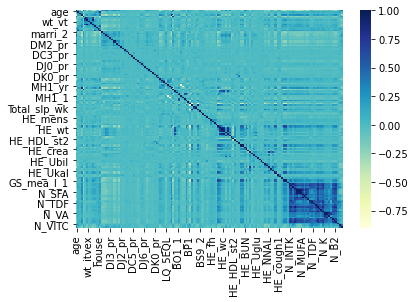

In [75]:
#변수간 상관관계 분석 - 2
sns.heatmap(df.corr(),cmap="YlGnBu")
t.head(200)

In [76]:
## VIF 산출
df['intercept'] = 1
lm = sm.OLS(df['HE_DM'], df)
results = lm.fit()
results.summary()

# dmatrix 사용을 위한 모든 변수에 대한 string +
cols = ''
for col in list(df):
    if(col=='sex'):
        cols = cols + str(col)
    else:
        cols = cols + ' + ' + str(col)
print(cols)

 + age + incm5 + ho_incm5 + edu + occp + wt_hs + wt_itvex + wt_vt + wt_nn + wt_ntr + cfam + allownc + house + ainc + marri_2 + D_1_1 + DI1_pr + DI2_pr + DI3_pr + DI4_pr + DM1_pr + DM2_pr + DM3_pr + DM4_pr + DJ2_pr + DJ4_pr + DC1_pr + DC2_pr + DC3_pr + DC4_pr + DC5_pr + DC6_pr + DC7_pr + DF2_pr + DL1_pr + DJ0_pr + DJ6_pr + DH4_pr + DH2_pr + DH3_pr + DH6_pr + DN1_pr + DK0_pr + DKNaN_pr + DK4_pr + BHNaN_11 + LQ4_00 + LQ1_sb + LQ_5EQL + MH1_yr + MO1_wk + educ + EC1_1 + BO1 + BO1_1 + BD1 + MH1_1 + MO1_1 + BD2 + BD1_11 + BP1 + BS1_1 + BS3_1 + Total_slp_wk + Total_slp_wd + BS2_1 + BS9_2 + BS13 + BE3_71 + BE3_31 + HE_mens + HE_prg + HE_fh + HE_DMfh1 + HE_DMfh2 + HE_DMfh3 + HE_ht + HE_wt + HE_wc + HE_BMI + HE_HbA1c + HE_obe + HE_DM + HE_chol + HE_HDL_st2 + HE_TG + HE_HBsAg + HE_hcv + HE_HB + HE_HCT + HE_BUN + HE_crea + HE_Uph + HE_Usg + HE_Unitr + HE_Upro + HE_Uglu + HE_Uket + HE_Ubil + HE_Ubld + HE_Uro + HE_Ucot + HE_NNAL + HE_UCREA + HE_UNa + HE_Ukal + HE_fvc + HE_pef + HE_cough1 + HE_sput1 +

In [77]:
## VIF 지수 산출 - 10 이상인 친구들     
y, X = dmatrices('HE_DM ~'+ cols , df, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
# ov_list=list(vif,list(vif['VIF Factor']>10))
# print(ov_list)
vif.head(200)
over_vif_vars = vif[vif['VIF Factor']>10]
over_vif_vars.head(200)

/Users/hobbes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/hobbes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
21,4.043849e+01,DM1_pr
22,3.584606e+01,DM2_pr
77,2.395742e+01,HE_ht
78,6.210794e+01,HE_wt
80,4.195306e+01,HE_BMI
89,1.719995e+01,HE_HB
90,1.678916e+01,HE_HCT
115,1.683424e+01,N_INTK
116,2.517504e+01,N_EN
118,1.429522e+01,N_PROT


In [85]:

# STEP 6 - 변수의 RF 모델에서 나온 중요도 산출 #########################################################################

#인코딩
df.loc[df["HE_DM"] == 1,"HE_DM"] = 0
df.loc[df["HE_DM"] == 2,"HE_DM"] = 0
df.loc[df["HE_DM"] == 3,"HE_DM"] = 1
df['HE_DM'].head(100)


importance_list = []
y = df.HE_DM # y축 설정
x = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(x_train,y_train)
for name, score in zip(df[:],rnd_clf.feature_importances_): ## RF 적 방법으로 변수 중요도 추출
    importance_list = importance_list + [name,score]
    print(name, round(score,6))

sex 0.001034
age 0.014648
incm5 0.002792
ho_incm5 0.002934
edu 0.004789
occp 0.003025
wt_hs 0.006724
wt_itvex 0.007035
wt_vt 0.004056
wt_nn 0.004417
wt_ntr 0.006674
cfam 0.003842
allownc 0.001022
house 0.001936
ainc 0.010888
marri_2 0.00161
D_1_1 0.003683
DI1_pr 0.01102
DI2_pr 0.009025
DI3_pr 0.001038
DI4_pr 0.000774
DM1_pr 0.000843
DM2_pr 0.000853
DM3_pr 0.000264
DM4_pr 0.000803
DJ2_pr 4e-06
DJ4_pr 0.000457
DC1_pr 0.000666
DC2_pr 0.0
DC3_pr 0.000257
DC4_pr 0.000303
DC5_pr 0.0
DC6_pr 4.7e-05
DC7_pr 0.000193
DF2_pr 0.000363
DL1_pr 6.8e-05
DJ0_pr 0.000492
DJ6_pr 0.000351
DH4_pr 0.00037
DH2_pr 0.001185
DH3_pr 0.000648
DH6_pr 0.000532
DN1_pr 0.000243
DK0_pr 0.000384
DKNaN_pr 0.000433
DK4_pr 0.00046
BHNaN_11 0.001018
LQ4_00 0.000813
LQ1_sb 0.000616
LQ_5EQL 0.001179
MH1_yr 0.00069
MO1_wk 0.000946
educ 0.006473
EC1_1 0.00109
BO1 0.003269
BO1_1 0.001526
BD1 0.000944
MH1_1 0.001251
MO1_1 0.002231
BD2 0.006087
BD1_11 0.00441
BP1 0.001943
BS1_1 0.00093
BS3_1 0.001644
Total_slp_wk 0.006796
Total_s

In [91]:
# STEP 7 - step5, step 6의 결론을 토대로 변수 drop ######################################################################
df = df.drop(['HE_HbA1c','HE_Uglu'],axis='columns')

In [92]:
#############STEP 7 - VIF 날림############
df=df.drop(['N_FAT','N_MUFA','N_N6','N_VA_RAE','N_CAROT','N_RETIN','N_PUFA','N_VA'],axis='columns')

In [93]:
#############STEP 7 - RF 중요도 날림#########3
df = df.drop(['DI4_pr','DM1_pr','DM2_pr','DM3_pr','DM4_pr','DJ2_pr','DJ4_pr','DC1_pr','DC2_pr','DC3_pr','DC3_pr','DC4_pr','DC5_pr','DC6_pr','DC7_pr','DF2_pr', 'DL1_pr', 'DJ0_pr', 'DJ6_pr', 'DH4_pr', 'DH3_pr', 'DH6_pr', 'DN1_pr', 'DK0_pr', 'DKNaN_pr', 'DK4_pr', 'LQ4_00', 'LQ1_sb', 'MH1_yr', 'MO1_wk','BD1','BS1_1','BS9_2','BE3_71','HE_mens','HE_prg','HE_DMfh1','HE_Usg','HE_Uket','HE_Ubld','HE_pef','HE_cough1'],axis='columns')
df.head()
############# STEP 7 - 52개 날라감  143 - 52 = 91 #####################

,sex,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DH2_pr,BHNaN_11,LQ_5EQL,educ,EC1_1,BO1,BO1_1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS13,BE3_31,HE_fh,HE_DMfh2,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Unitr,HE_Upro,HE_Ubil,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR,intercept
0,1,80,2,1,3,7,7129.611906,11065.346820,48804.43027,14516.42326,12602.663140,3,20,2,80.000000,3,3,1,1,0,0,1,1,5,2,4,1,0,0,19,2,4,3,480,480,19,2,6,0,0,0,162.4,56.0,82.2,21.233226,2,0,111,43,83,0.55,0.08,12.9,38.7,27,1.48,6.5,0,0,0,0,2.5700,1.4,68.9,87,35,3.12,0,5,19.2,16.8,5.0,584.617278,843.068846,413.229839,36.421414,6.574070,0.573964,104.511252,97.066580,8.024705,14.110607,137.524220,467.694365,4.771832,1327.693537,944.539521,0.664332,0.509876,4.700086,5.846040,53.215661,10,1
1,1,78,5,5,4,1,7129.611906,3688.448941,19970.18814,14516.42326,4200.887713,2,20,3,1500.000000,1,1,0,0,0,0,1,1,7,1,4,1,0,0,15,5,4,0,300,420,0,2,4,0,0,0,167.7,76.4,98.3,27.166096,4,1,224,36,157,0.51,0.10,14.3,42.6,22,0.95,5.5,0,0,0,0,0.3960,1.4,100.1,182,38,3.22,0,5,40.5,35.9,5.0,1573.428467,1784.794052,1008.012946,93.260455,7.572577,0.333173,206.181421,298.257700,39.887760,93.915511,430.240874,941.809087,11.041512,4961.541083,3658.637056,1.175553,1.217959,16.821098,109.102194,83.316037,10,1
2,2,75,5,5,3,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,20,3,1500.000000,1,3,1,0,0,1,1,1,5,2,4,1,0,2,0,0,3,0,360,480,0,1,2,1,0,1,157.7,53.2,80.7,21.391845,2,1,165,44,101,0.59,12.06,14.3,42.3,15,0.57,6.0,0,0,0,0,0.7875,1.4,105.1,153,66,1.72,0,5,15.3,10.3,5.0,1194.733365,1984.263560,758.479721,42.516444,23.130683,2.193219,495.097017,320.072436,44.459450,120.949600,342.242264,842.370409,7.348493,2087.228977,3072.114196,0.638100,1.337223,4.785608,96.546711,78.771586,10,1
3,2,80,2,1,1,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,20,1,75.666667,3,1,0,0,0,0,1,1,3,2,3,1,0,1,0,0,4,0,450,450,0,2,4,0,0,0,146.1,57.6,93.0,26.984977,4,1,160,32,229,0.52,0.06,10.3,30.2,23,0.98,5.0,0,0,0,0,0.4480,1.4,67.3,140,35,2.24,0,2,8.6,14.6,2.5,526.064249,1019.718446,271.549260,24.806971,2.329953,0.356655,3.729000,211.241049,16.174439,22.942586,146.555175,609.814863,5.071129,2886.722704,1244.294594,0.877007,0.305087,6.082442,10.749817,51.281633,10,1
4,2,71,2,1,4,7,7129.611906,3315.581424,19970.18814,14516.42326,3268.787290,2,20,1,75.666667,4,3,1,0,0,0,1,1,7,2,2,1,0,1,21,1,4,0,300,360,0,2,0,1,0,1,157.2,53.2,78.4,21.528142,2,1,167,62,54,0.64,0.04,12.6,37.5,25,0.71,6.0,0,0,0,0,0.8110,1.4,62.7,159,38,2.43,0,2,15.3,14.3,10.0,1271.085794,1286.795194,540.182372,35.319840,16.748430,0.312280,65.398719,221.474668,20.316407,78.265128,587.222358,793.749899,4.773000,605.814716,2280.084010,0.646209,1.248963,6.526215,36.724796,76.575833,10,1


0.9139633286318759


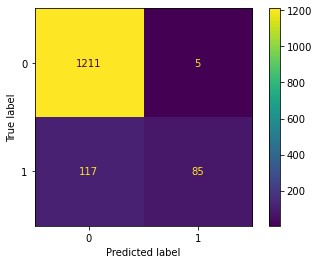

In [86]:
# STEP 8 - 파이프라이닝 - 스케일링 / 모델링 결정  ########################################################################

## 데이터 분류 및 전처리
# 축 분리#te
Y = df.HE_DM # y축 설정
X = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions

# 사이킷런 셋 분류 함수 : http://blog.naver.com/PostView.nhn?blogId=siniphia&logNo=221396370872
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42) ## test.size 0.2~0.25 설정할거임


pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train,Y_train)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
plot_confusion_matrix(pipe,X_test,Y_test)

In [ ]:
##########################PHASE2######################
# STEP 4 - Data에 대한 구조와 분석
df.hist(figsize=(20,20))#histogram plotting
#sns.paiplot(df)
df.head()
df['HE_DM']

In [87]:
# STEP 5 = 변수간 상관관계 및 다중공선성(VIF) 분석 #################################################################### 

## 변수간 상관관계 분석 - 1 
t=df.corr(method='pearson') ## de1_pr 현재 당뇨병 유병 여부와 상관관계가 있는 변수들
t.HE_DM

sex            -0.076824
age             0.239156
incm5          -0.063974
ho_incm5       -0.030127
edu            -0.191204
occp            0.117487
wt_hs          -0.010544
wt_itvex       -0.077555
wt_vt          -0.022300
wt_nn          -0.035757
wt_ntr         -0.072860
cfam           -0.144739
allownc        -0.069189
house          -0.000232
ainc           -0.144718
marri_2         0.066143
D_1_1           0.149395
DI1_pr          0.260335
DI2_pr          0.230516
DI3_pr          0.085945
DI4_pr          0.080109
DM1_pr          0.064871
DM2_pr          0.069175
DM3_pr          0.003239
DM4_pr          0.034586
DJ2_pr         -0.010011
DJ4_pr          0.025875
DC1_pr          0.035093
DC2_pr         -0.010011
DC3_pr          0.006413
DC4_pr         -0.016393
DC5_pr         -0.005778
DC6_pr          0.003159
DC7_pr         -0.025900
DF2_pr          0.022771
DL1_pr         -0.015636
DJ0_pr         -0.066518
DJ6_pr          0.007833
DH4_pr          0.014857
DH2_pr          0.064259


In [57]:
# STEP 5 = 변수간 상관관계 및 다중공선성(VIF) 분석 #################################################################### 

## 변수간 상관관계 분석 - 1 
t=df.corr(method='pearson') ## de1_pr 현재 당뇨병 유병 여부와 상관관계가 있는 변수들
t.HE_DM

sex            -0.076824
age             0.239156
incm5          -0.063974
ho_incm5       -0.030127
edu            -0.191204
occp            0.117487
wt_hs          -0.010544
wt_itvex       -0.077555
wt_vt          -0.022300
wt_nn          -0.035757
wt_ntr         -0.072860
cfam           -0.144739
allownc        -0.069189
house          -0.000232
ainc           -0.144718
marri_2         0.066143
D_1_1           0.149395
DI1_pr          0.260335
DI2_pr          0.230516
DI3_pr          0.085945
DH2_pr          0.064259
BHNaN_11       -0.104962
LQ_5EQL         0.035422
educ           -0.184638
EC1_1           0.085002
BO1             0.059861
BO1_1          -0.035070
MH1_1           0.008701
MO1_1           0.035538
BD2             0.000586
BD1_11         -0.049406
BP1             0.036391
BS3_1           0.063373
Total_slp_wk    0.009047
Total_slp_wd   -0.043168
BS2_1           0.058243
BS13           -0.005335
BE3_31          0.008557
HE_fh          -0.001832
HE_DMfh2        0.067290


In [88]:
## VIF 산출
df['intercept'] = 1
lm = sm.OLS(df['HE_DM'], df)
results = lm.fit()
results.summary()

# dmatrix 사용을 위한 모든 변수에 대한 string +
cols = ''
for col in list(df):
    if(col=='sex'):
        cols = cols + str(col)
    else:
        cols = cols + ' + ' + str(col)
print(cols)

sex + age + incm5 + ho_incm5 + edu + occp + wt_hs + wt_itvex + wt_vt + wt_nn + wt_ntr + cfam + allownc + house + ainc + marri_2 + D_1_1 + DI1_pr + DI2_pr + DI3_pr + DI4_pr + DM1_pr + DM2_pr + DM3_pr + DM4_pr + DJ2_pr + DJ4_pr + DC1_pr + DC2_pr + DC3_pr + DC4_pr + DC5_pr + DC6_pr + DC7_pr + DF2_pr + DL1_pr + DJ0_pr + DJ6_pr + DH4_pr + DH2_pr + DH3_pr + DH6_pr + DN1_pr + DK0_pr + DKNaN_pr + DK4_pr + BHNaN_11 + LQ4_00 + LQ1_sb + LQ_5EQL + MH1_yr + MO1_wk + educ + EC1_1 + BO1 + BO1_1 + BD1 + MH1_1 + MO1_1 + BD2 + BD1_11 + BP1 + BS1_1 + BS3_1 + Total_slp_wk + Total_slp_wd + BS2_1 + BS9_2 + BS13 + BE3_71 + BE3_31 + HE_mens + HE_prg + HE_fh + HE_DMfh1 + HE_DMfh2 + HE_DMfh3 + HE_ht + HE_wt + HE_wc + HE_BMI + HE_HbA1c + HE_obe + HE_DM + HE_chol + HE_HDL_st2 + HE_TG + HE_HBsAg + HE_hcv + HE_HB + HE_HCT + HE_BUN + HE_crea + HE_Uph + HE_Usg + HE_Unitr + HE_Upro + HE_Uglu + HE_Uket + HE_Ubil + HE_Ubld + HE_Uro + HE_Ucot + HE_NNAL + HE_UCREA + HE_UNa + HE_Ukal + HE_fvc + HE_pef + HE_cough1 + HE_sput

In [59]:
## VIF 지수 산출 - 10 이상인 친구들     
y, X = dmatrices('HE_DM ~'+ cols , df, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
# ov_list=list(vif,list(vif['VIF Factor']>10))
# print(ov_list)
vif.head(200)
over_vif_vars = vif[vif['VIF Factor']>10]
over_vif_vars.head(200)

/Users/hobbes/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
42,23.607829,HE_ht
43,60.825181,HE_wt
45,41.075325,HE_BMI
53,16.887800,HE_HB
54,16.288114,HE_HCT
73,16.073947,N_INTK
74,22.181773,N_EN
76,13.211910,N_PROT
84,18.532534,N_PHOS


In [94]:
# STEP 6 - 변수의 RF 모델에서 나온 중요도 산출 #########################################################################

importance_list = []
y = df.HE_DM # y축 설정
x = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(x_train,y_train)
for name, score in zip(df[:],rnd_clf.feature_importances_): ## RF 적 방법으로 변수 중요도 추출
    importance_list = importance_list + [name,score]
    print(name, round(score,6))

sex 0.001941
age 0.024845
incm5 0.005763
ho_incm5 0.005289
edu 0.006222
occp 0.005128
wt_hs 0.011995
wt_itvex 0.012811
wt_vt 0.006041
wt_nn 0.008948
wt_ntr 0.013194
cfam 0.005878
allownc 0.001464
house 0.003581
ainc 0.018926
marri_2 0.002981
D_1_1 0.005892
DI1_pr 0.017201
DI2_pr 0.014958
DI3_pr 0.001932
DH2_pr 0.001743
BHNaN_11 0.001887
LQ_5EQL 0.002387
educ 0.009795
EC1_1 0.001615
BO1 0.005686
BO1_1 0.002984
MH1_1 0.00179
MO1_1 0.003959
BD2 0.010467
BD1_11 0.007526
BP1 0.003513
BS3_1 0.002839
Total_slp_wk 0.011198
Total_slp_wd 0.011061
BS2_1 0.007472
BS13 0.001682
BE3_31 0.006983
HE_fh 0.0018
HE_DMfh2 0.003029
HE_DMfh3 0.018247
HE_ht 0.012999
HE_wt 0.017214
HE_wc 0.032686
HE_BMI 0.017014
HE_obe 0.005352
HE_DM 0.042636
HE_chol 0.020755
HE_HDL_st2 0.02497
HE_TG 0.014781
HE_HBsAg 0.011661
HE_hcv 0.015242
HE_HB 0.016945
HE_HCT 0.019216
HE_BUN 0.019621
HE_crea 0.006832
HE_Uph 0.001655
HE_Unitr 0.010992
HE_Upro 0.000867
HE_Ubil 0.000567
HE_Uro 0.014935
HE_Ucot 0.009942
HE_NNAL 0.015897
HE_U

In [96]:
# STEP 7 - step5, step 6의 결론을 토대로 변수 drop ######################################################################
df.drop(['HE_wt','HE_HB','N_EN'],axis='columns')

,sex,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DH2_pr,BHNaN_11,LQ_5EQL,educ,EC1_1,BO1,BO1_1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS13,BE3_31,HE_fh,HE_DMfh2,HE_DMfh3,HE_ht,HE_wc,HE_BMI,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Unitr,HE_Upro,HE_Ubil,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_WATER,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR,intercept
0,1,80,2,1,3,7,7129.611906,11065.346820,48804.430270,14516.423260,12602.663140,3,20,2,80.000000,3,3,1,1,0,0,1,1,5,2,4,1,0,0,19,2,4,3,480,480,19,2,6,0,0,0,162.4,82.2,21.233226,2,0,111,43,83,0.55,0.08,38.7,27,1.48,6.5,0,0,0,0,2.5700,1.400,68.9,87,35,3.12,0,5,19.2,16.8,5.0,584.617278,413.229839,36.421414,6.574070,0.573964,104.511252,97.066580,8.024705,14.110607,137.524220,467.694365,4.771832,1327.693537,944.539521,0.664332,0.509876,4.700086,5.846040,53.215661,10,1
1,1,78,5,5,4,1,7129.611906,3688.448941,19970.188140,14516.423260,4200.887713,2,20,3,1500.000000,1,1,0,0,0,0,1,1,7,1,4,1,0,0,15,5,4,0,300,420,0,2,4,0,0,0,167.7,98.3,27.166096,4,1,224,36,157,0.51,0.10,42.6,22,0.95,5.5,0,0,0,0,0.3960,1.400,100.1,182,38,3.22,0,5,40.5,35.9,5.0,1573.428467,1008.012946,93.260455,7.572577,0.333173,206.181421,298.257700,39.887760,93.915511,430.240874,941.809087,11.041512,4961.541083,3658.637056,1.175553,1.217959,16.821098,109.102194,83.316037,10,1
2,2,75,5,5,3,7,7129.611906,5244.077972,19970.188140,14516.423260,5622.287006,2,20,3,1500.000000,1,3,1,0,0,1,1,1,5,2,4,1,0,2,0,0,3,0,360,480,0,1,2,1,0,1,157.7,80.7,21.391845,2,1,165,44,101,0.59,12.06,42.3,15,0.57,6.0,0,0,0,0,0.7875,1.400,105.1,153,66,1.72,0,5,15.3,10.3,5.0,1194.733365,758.479721,42.516444,23.130683,2.193219,495.097017,320.072436,44.459450,120.949600,342.242264,842.370409,7.348493,2087.228977,3072.114196,0.638100,1.337223,4.785608,96.546711,78.771586,10,1
3,2,80,2,1,1,7,7129.611906,5244.077972,19970.188140,14516.423260,5622.287006,2,20,1,75.666667,3,1,0,0,0,0,1,1,3,2,3,1,0,1,0,0,4,0,450,450,0,2,4,0,0,0,146.1,93.0,26.984977,4,1,160,32,229,0.52,0.06,30.2,23,0.98,5.0,0,0,0,0,0.4480,1.400,67.3,140,35,2.24,0,2,8.6,14.6,2.5,526.064249,271.549260,24.806971,2.329953,0.356655,3.729000,211.241049,16.174439,22.942586,146.555175,609.814863,5.071129,2886.722704,1244.294594,0.877007,0.305087,6.082442,10.749817,51.281633,10,1
4,2,71,2,1,4,7,7129.611906,3315.581424,19970.188140,14516.423260,3268.787290,2,20,1,75.666667,4,3,1,0,0,0,1,1,7,2,2,1,0,1,21,1,4,0,300,360,0,2,0,1,0,1,157.2,78.4,21.528142,2,1,167,62,54,0.64,0.04,37.5,25,0.71,6.0,0,0,0,0,0.8110,1.400,62.7,159,38,2.43,0,2,15.3,14.3,10.0,1271.085794,540.182372,35.319840,16.748430,0.312280,65.398719,221.474668,20.316407,78.265128,587.222358,793.749899,4.773000,605.814716,2280.084010,0.646209,1.248963,6.526215,36.724796,76.575833,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721,2,35,4,1,4,1,1351.114699,1424.263279,3348.046704,14516.423260,1403.756335,6,20,2,677.500000,1,2,0,0,0,0,1,1,7,1,3,1,0,0,19,4,4,0,510,510,0,2,2,1,0,0,159.8,70.1,21.773149,2,0,185,46,121,0.34,0.06,40.2,14,0.67,5.0,0,0,0,0,0.7875,1.400,140.4,94,55,3.12,0,5,31.9,26.9,2.0,1781.776105,1165.829358,92.198711,15.402060,2.212394,386.908388,326.026870,19.915406,53.574344,750.121366,1394.802936,21.982038,5421.978395,2919.595466,1.086516,2.025690,14.034141,35.635696,83.315869,10,1
4722,2,66,5,1,2,6,1351.114699,819.485165,19970.188140,2047.985128,954.816789,6,20,2,677.500000,3,4,0,1,0,0,1,2,4,1,4,2,0,0,55,3,3,0,420,465,0,2,6,1,0,1,156.9,87.3,25.957028,4,

In [100]:
#############STEP 7 - RF 중요도 날림#########3
df=df.drop(['sex','allownc','house','marri_2','DI3_pr','DH2_pr','BHNaN_11','LQ_5EQL','EC1_1', 'BO1_1', 'MH1_1', 'MO1_1', 'BP1', 'BS3_1', 'BS13','HE_fh', 'HE_DMfh2','HE_Upro','HE_Ubil','HE_fvc','HEI_BR','HEI'],axis='columns')
df.head()
############# STEP 7 - 52개 날라감  91 - 25 = 91 #####################

,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,ainc,D_1_1,DI1_pr,DI2_pr,educ,BO1,BD2,BD1_11,Total_slp_wk,Total_slp_wd,BS2_1,BE3_31,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Unitr,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_B1,N_B2,N_NIAC,N_VITC,intercept
0,80,2,1,3,7,7129.611906,11065.346820,48804.43027,14516.42326,12602.663140,3,80.000000,3,1,1,5,4,19,2,480,480,19,6,0,162.4,56.0,82.2,21.233226,2,0,111,43,83,0.55,0.08,12.9,38.7,27,1.48,6.5,0,0,2.5700,1.4,68.9,87,35,0,5,19.2,16.8,5.0,584.617278,843.068846,413.229839,36.421414,6.574070,0.573964,104.511252,97.066580,8.024705,14.110607,137.524220,467.694365,4.771832,1327.693537,944.539521,0.664332,0.509876,4.700086,5.846040,1
1,78,5,5,4,1,7129.611906,3688.448941,19970.18814,14516.42326,4200.887713,2,1500.000000,1,0,0,7,4,15,5,300,420,0,4,0,167.7,76.4,98.3,27.166096,4,1,224,36,157,0.51,0.10,14.3,42.6,22,0.95,5.5,0,0,0.3960,1.4,100.1,182,38,0,5,40.5,35.9,5.0,1573.428467,1784.794052,1008.012946,93.260455,7.572577,0.333173,206.181421,298.257700,39.887760,93.915511,430.240874,941.809087,11.041512,4961.541083,3658.637056,1.175553,1.217959,16.821098,109.102194,1
2,75,5,5,3,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,1500.000000,3,1,0,5,4,0,0,360,480,0,2,1,157.7,53.2,80.7,21.391845,2,1,165,44,101,0.59,12.06,14.3,42.3,15,0.57,6.0,0,0,0.7875,1.4,105.1,153,66,0,5,15.3,10.3,5.0,1194.733365,1984.263560,758.479721,42.516444,23.130683,2.193219,495.097017,320.072436,44.459450,120.949600,342.242264,842.370409,7.348493,2087.228977,3072.114196,0.638100,1.337223,4.785608,96.546711,1
3,80,2,1,1,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,75.666667,1,0,0,3,3,0,0,450,450,0,4,0,146.1,57.6,93.0,26.984977,4,1,160,32,229,0.52,0.06,10.3,30.2,23,0.98,5.0,0,0,0.4480,1.4,67.3,140,35,0,2,8.6,14.6,2.5,526.064249,1019.718446,271.549260,24.806971,2.329953,0.356655,3.729000,211.241049,16.174439,22.942586,146.555175,609.814863,5.071129,2886.722704,1244.294594,0.877007,0.305087,6.082442,10.749817,1
4,71,2,1,4,7,7129.611906,3315.581424,19970.18814,14516.42326,3268.787290,2,75.666667,3,1,0,7,2,21,1,300,360,0,0,1,157.2,53.2,78.4,21.528142,2,1,167,62,54,0.64,0.04,12.6,37.5,25,0.71,6.0,0,0,0.8110,1.4,62.7,159,38,0,2,15.3,14.3,10.0,1271.085794,1286.795194,540.182372,35.319840,16.748430,0.312280,65.398719,221.474668,20.316407,78.265128,587.222358,793.749899,4.773000,605.814716,2280.084010,0.646209,1.248963,6.526215,36.724796,1


0.8582510578279267


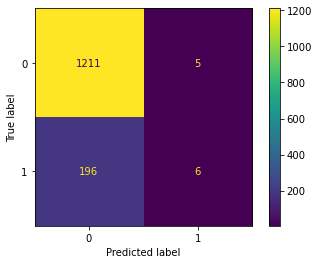

In [101]:
# STEP 8 - 파이프라이닝 - 스케일링 / 모델링 결정  ########################################################################

## 데이터 분류 및 전처리
# 축 분리#te
Y = df.HE_DM # y축 설정
X = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions

# 사이킷런 셋 분류 함수 : http://blog.naver.com/PostView.nhn?blogId=siniphia&logNo=221396370872
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42) ## test.size 0.2~0.25 설정할거임


pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train,Y_train)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
plot_confusion_matrix(pipe,X_test,Y_test)